## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All imports successful!")

Matplotlib is building the font cache; this may take a moment.


All imports successful!


## Part 1: Data Loading and Initial Exploration

In [ ]:
df = pd.read_csv('../delivery_data.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (1000, 7)

First few rows:
             timestamp  distance_km weather_condition traffic_level  \
0  2023-01-11 23:15:00          6.4             Sunny           Low   
1  2023-01-01 14:20:00          7.9             Sunny          High   
2  2023-01-27 11:58:00         13.3             Sunny        Medium   
3  2023-02-01 01:32:00         11.8             Sunny           Low   
4  2023-01-08 20:04:00          7.8             Rainy           Low   

   package_weight  driver_rating  delivery_time_minutes  
0            -1.0            NaN                   33.0  
1            25.0            3.7                   46.0  
2            25.3            3.8                   46.0  
3            11.5            4.2                   30.0  
4            19.1            4.6                   42.0  

Data types:
timestamp                 object
distance_km              float64
weather_condition         object
traffic_level             object
package_weight           float64
drive

## Part 2: Data Cleaning and Feature Engineering

### 2.1 Handle Erronous Values

### 2.2 Feature Extraction


In [ ]:
df_clean = df.copy()

print("Original dataset:")
print(f"  Negative weights: {(df_clean['package_weight'] < 0).sum()}")
print(f"  Missing driver_rating: {df_clean['driver_rating'].isnull().sum()}")


median_rating = df_clean['driver_rating'].median()
df_clean['driver_rating'].fillna(median_rating, inplace=True)
print(f"\nImputed missing driver_rating with median value: {median_rating}")


df_clean['package_weight'] = df_clean['package_weight'].abs()
print(f"Converted negative package weights to absolute values")


df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])


df_clean['hour_of_day'] = df_clean['timestamp'].dt.hour


df_clean['day_of_week'] = df_clean['timestamp'].dt.dayofweek


df_clean['month'] = df_clean['timestamp'].dt.month

print("\nFeature Engineering Complete:")
print(f"  - hour_of_day: Represents delivery hour (0-23)")
print(f"  - day_of_week: Represents day of week (0=Mon, 6=Sun)")
print(f"  - month: Represents month of year (1-12)")

print("\nDataset after cleaning:")
print(f"  Missing values: {df_clean.isnull().sum().sum()}")
print(f"  Negative weights: {(df_clean['package_weight'] < 0).sum()}")
print(f"\nNew columns:")
print(df_clean[['timestamp', 'hour_of_day', 'day_of_week', 'month']].head())

Original dataset:
  Negative weights: 20
  Missing driver_rating: 50

Imputed missing driver_rating with median value: 4.0
Converted negative package weights to absolute values

Feature Engineering Complete:
  - hour_of_day: Represents delivery hour (0-23)
  - day_of_week: Represents day of week (0=Mon, 6=Sun)
  - month: Represents month of year (1-12)

Dataset after cleaning:
  Missing values: 0
  Negative weights: 0

New columns:
            timestamp  hour_of_day  day_of_week  month
0 2023-01-11 23:15:00           23            2      1
1 2023-01-01 14:20:00           14            6      1
2 2023-01-27 11:58:00           11            4      1
3 2023-02-01 01:32:00            1            2      2
4 2023-01-08 20:04:00           20            6      1


## Part 3: Prepare Data for Modeling

In [ ]:
feature_columns = ['distance_km', 'package_weight', 'driver_rating', 
                   'hour_of_day', 'day_of_week', 'month',
                   'weather_condition', 'traffic_level']

X = df_clean[feature_columns].copy()
y = df_clean['delivery_time_minutes'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures:")
print(X.head())
print(f"\nTarget (delivery_time_minutes):")
print(y.head())

Feature matrix shape: (1000, 8)
Target shape: (1000,)

Features:
   distance_km  package_weight  driver_rating  hour_of_day  day_of_week  \
0          6.4             1.0            4.0           23            2   
1          7.9            25.0            3.7           14            6   
2         13.3            25.3            3.8           11            4   
3         11.8            11.5            4.2            1            2   
4          7.8            19.1            4.6           20            6   

   month weather_condition traffic_level  
0      1             Sunny           Low  
1      1             Sunny          High  
2      1             Sunny        Medium  
3      2             Sunny           Low  
4      1             Rainy           Low  

Target (delivery_time_minutes):
0    33.0
1    46.0
2    46.0
3    30.0
4    42.0
Name: delivery_time_minutes, dtype: float64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set features:")
print(X_train.head())

Training set size: 800
Test set size: 200

Training set features:
     distance_km  package_weight  driver_rating  hour_of_day  day_of_week  \
29          11.6            22.9            3.9            3            6   
535         12.1            25.4            4.7           17            3   
695         12.0             5.6            3.5           17            6   
557         16.1             9.0            3.5            5            0   
836          5.3             9.3            3.6           16            5   

     month weather_condition traffic_level  
29       1            Cloudy           Low  
535      1            Cloudy        Medium  
695      1            Cloudy           Low  
557      1            Stormy          High  
836      2             Rainy           Low  


## Part 4: Build Custom Pipeline to Handle Preprocessing

**Data Leakage Prevention:**
- Train-test split is done BEFORE any preprocessing
- Scaler is fit ONLY on training data
- Test data is transformed using the same scaler fitted on training data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


numeric_features = ['distance_km', 'package_weight', 'driver_rating', 
                   'hour_of_day', 'day_of_week', 'month']
categorical_features = ['weather_condition', 'traffic_level']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print("Pipeline created successfully!")
print(pipeline)

Pipeline created successfully!
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['distance_km',
                                                   'package_weight',
                                                   'driver_rating',
                                                   'hour_of_day', 'day_of_week',
                                                   'month']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['weather_condition',
                                                   'traffic_level'])])),
                ('regressor', LinearRegression())])


## Part 5: Train the Model

In [ ]:
print("Training the model...")
pipeline.fit(X_train, y_train)
print("✅ Model training complete!")

Training the model...
✅ Model training complete!


## Part 6: Make Predictions and Evaluate

In [ ]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)


train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)


test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print("\nTRAINING SET:")
print(f"  Mean Squared Error (MSE):    {train_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {train_rmse:.4f} minutes")
print(f"  Mean Absolute Error (MAE):   {train_mae:.4f} minutes")
print(f"  R² Score:                    {train_r2:.4f}")

print("\nTEST SET:")
print(f"  Mean Squared Error (MSE):    {test_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {test_rmse:.4f} minutes")
print(f"  Mean Absolute Error (MAE):   {test_mae:.4f} minutes")
print(f"  R² Score:                    {test_r2:.4f}")
print("="*60)

print("\nInterpretation:")
print(f"  - On average, predictions are off by ~{test_mae:.2f} minutes (MAE)")
print(f"  - The model explains {test_r2*100:.2f}% of variance in delivery times")
print(f"  - Typical prediction error (RMSE): {test_rmse:.2f} minutes")

MODEL PERFORMANCE METRICS

TRAINING SET:
  Mean Squared Error (MSE):    23.9284
  Root Mean Squared Error (RMSE): 4.8917 minutes
  Mean Absolute Error (MAE):   3.8715 minutes
  R² Score:                    0.8841

TEST SET:
  Mean Squared Error (MSE):    22.5267
  Root Mean Squared Error (RMSE): 4.7462 minutes
  Mean Absolute Error (MAE):   3.7132 minutes
  R² Score:                    0.8937

Interpretation:
  - On average, predictions are off by ~3.71 minutes (MAE)
  - The model explains 89.37% of variance in delivery times
  - Typical prediction error (RMSE): 4.75 minutes


## Part 7: Visualization - Actual vs Predicted

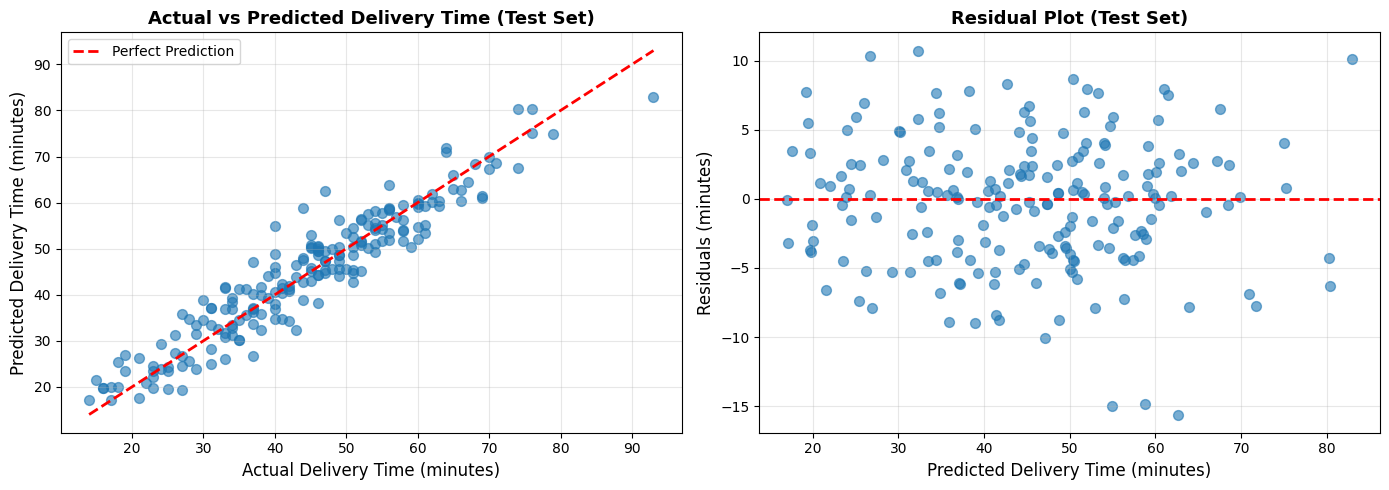

✅ Visualization saved to 'results_visualization.png'


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].scatter(y_test, y_test_pred, alpha=0.6, s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Delivery Time (minutes)', fontsize=12)
axes[0].set_ylabel('Predicted Delivery Time (minutes)', fontsize=12)
axes[0].set_title('Actual vs Predicted Delivery Time (Test Set)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)


residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.6, s=50)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Delivery Time (minutes)', fontsize=12)
axes[1].set_ylabel('Residuals (minutes)', fontsize=12)
axes[1].set_title('Residual Plot (Test Set)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to 'results_visualization.png'")

## Part 8: Feature Importance Analysis


Feature Importance (by Coefficient Magnitude):
                 Feature  Coefficient  Abs_Coefficient
weather_condition_Stormy    18.009232        18.009232
       traffic_level_Low   -14.821147        14.821147
             distance_km    11.042618        11.042618
    traffic_level_Medium    -9.905952         9.905952
 weather_condition_Rainy     9.280108         9.280108
 weather_condition_Sunny    -1.406200         1.406200
                   month     0.248433         0.248433
             day_of_week     0.232036         0.232036
           driver_rating    -0.217631         0.217631
             hour_of_day    -0.178747         0.178747
          package_weight    -0.025226         0.025226


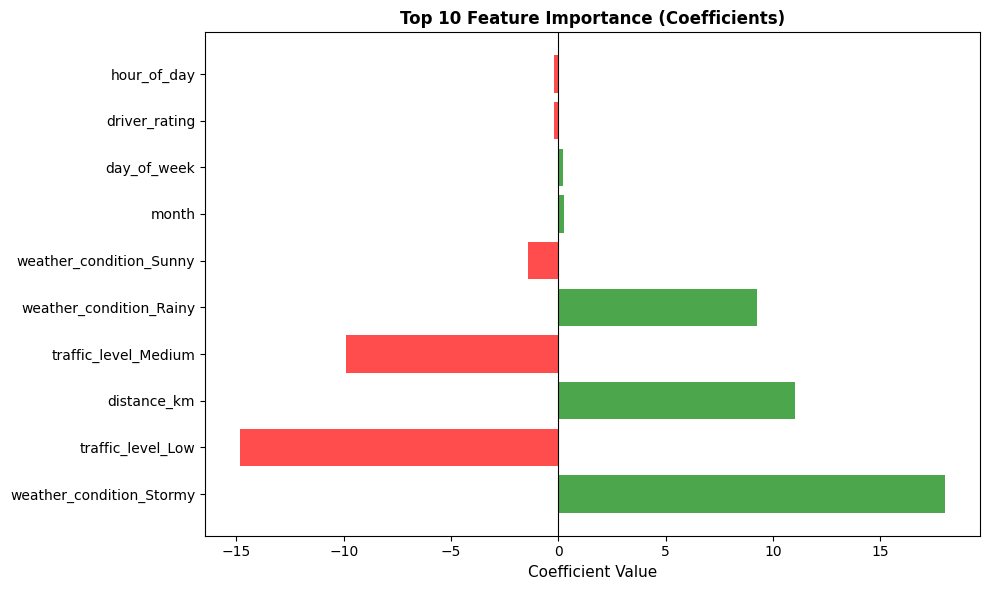


✅ Feature importance visualization saved to 'feature_importance.png'


In [ ]:
model = pipeline.named_steps['regressor']
preprocessor = pipeline.named_steps['preprocessor']


numeric_names = numeric_features
categorical_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_names + categorical_names


coefficients = model.coef_
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance (by Coefficient Magnitude):")
print(feature_importance.to_string(index=False))


top_features = feature_importance.head(10)
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontsize=11)
plt.title('Top 10 Feature Importance (Coefficients)', fontsize=12, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.savefig('../feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance visualization saved to 'feature_importance.png'")